# TESS Light Curve Analysis with lightkurve

We are going to analyze transit light curves of our planets from the Transiting Exoplanet Survey Satellite (TESS) with the [lightkurve](https://docs.lightkurve.org/) software in this tutorial. You can easily install lightkurve to your system following the [installation instructions](https://docs.lightkurve.org/about/install.html). 

TESS transmits every image it acquires from all of its 16 CCDs (4 telescopes equipped with 4 CCDs each) every 30 minutes (now 10 minutes with the new image compression technique) in the FITS format as Full Frame Images (FFIs). However it records its photometric measurements from a $11 \times 11$ pixel field defined for a limited number of stars (including yours) every 2 minutes (now 10 seconds with the new image compression technique) as Target Pixel Files (TPFs). Target pixel files have all the information about the small field around the target from which 3 types of photometric science products are obtained by the lightkurve program: 

* Simple Aperture Photometry (SAP)
* Pre-search Data Conditioning SAP flux (PDCSAP)
* Data Validation Timeseries File (DVT Files)

We are going to analyze all these three products (SAP, PDC-SAP, DVT) with the lightkurve software and TPF-generated light curve with the same aperture mask that SAP is based on to understand how they are produced. However you are going to use $DVT$ (Data Validation Timeseries) files for your analysis or $PDCSAP$ if there is no DVT-file. 

## Search and download TESS data for your targets

First we search for the target (HAT-P-36 in this case as an example) from this [link](https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py) to see if it was obsrved or not. You can also search in the Science Telescope Science Institute's mirror for [Mikulski Archive for Space Telescopes (MAST) ](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html). You can see the exposure time and the sector number in which your target is observed as well as its SAP-light curve in the portal if you provide its name in the search box. TESS is an all-sky telescope; however, it observes particular regions in the sky for ~28 days with 4 different small telescopes and change the field of view then. Each of these observation intervals is called a <i>sector</i>  HAT-P-36 was observed in sector-22 so we search for download its data first after importing the required packages.

In [1]:
# imports
from matplotlib import pyplot as plt
%matplotlib notebook
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk

SearchResult containing 1 data products.

 #     mission     year  author exptime target_name distance
                                   s                 arcsec 
--- -------------- ---- ------- ------- ----------- --------
  0 TESS Sector 22 2020 TESScut    1426    HAT-P-36      0.0


0% (2/1248) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


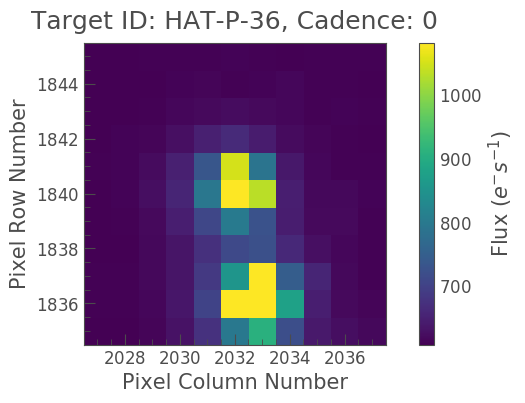

In [2]:
%matplotlib inline
# Search for the target in a specific sector
# and download the cut-out from FFI
search_result = lk.search_tesscut('HAT-P-36', sector=22)
print(search_result)
lk.log.setLevel('INFO')
# quality bitmask 175 is for severe quality issues
# and we are going to cut a 11 pixel TPF for comparison with SAP
# extracted from of a TPF of the same size
tpf_30min_11px = search_result.download(cutout_size=11, quality_bitmask=175)
tpf_30min_11px.plot()

The object in the middle of this TPF is the target. You can see that there is a nearby but an isolated objected which does not contaminate the pixels that the target occupies. However, it might not be the case for you. Then please let us know and we'll show how to disentangle the light from your source if it is possible. We can (and are going to) use this light curve file for analysis. But for the time being we are going to generate a light curve from the target pixel (TPF). file too  

## Generate and examine the 2-min cadence light curve from TPF

For the ease of use we downloaded all the TPF, LC and DVT files in a compressed file from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) by just clicking the save button next to the row where the 2-minute (120 second)-exposure observation is listed. Now let's open the target pixel file for the 2-minute cadence data, plot, and  examine. The info show that the aperture is stored in the 3rd (#2) extension, the image is in 1, header is in 0, and the target cosmic ray information is in 3 from the info method.

In [3]:
# TPF is externally downloaded from the MAST for ease of use and repetition
tpf_2min_11px_file = "tess2020049080258-s0022-0000000373693175-0174-s_tp.fits"
fits.info(tpf_2min_11px_file)
tpf_2min_11px = lk.TessTargetPixelFile(tpf_2min_11px_file)

Filename: tess2020049080258-s0022-0000000373693175-0174-s_tp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   19579R x 11C   [D, E, J, 121J, 121E, 121E, 121E, 121E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   


5% (954/19579) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


As it can be seen from the error message ~1000 measurements were already eliminated (ignored) due to their quality. This is ensured by the `quality_mask` parameter, whose default is 175 (only cadences with severe quality issues will be ignored). You can find more information [here](https://docs.lightkurve.org/reference/api/lightkurve.TessTargetPixelFile.html) for this parameter. Now let's plot this and see the same target pixels in the downloaded file from the MAST.

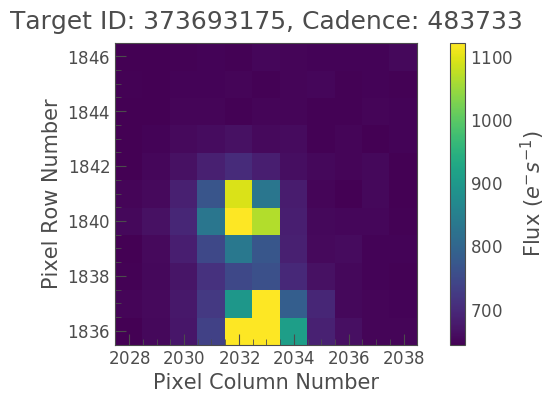

In [4]:
tpf_2min_11px.plot()

## Interactive Sky Map with Position from Gaia

If there's a contaminating source in close vicinity of your target, you might want to look at it and have some information about it. This is possible thanks to data from another space telescope, Gaia, which was sent to space to determine primarily the accurate and precise positions of celestial objects. Since TESS can not observe faint targets. We limited the magnitude of our objects by 15 magnitude and look at only the brighter ones (with smaller magnitude values).

In [5]:
tpf_2min_11px.interact_sky(notebook_url='localhost:8889', magnitude_limit=15)

## Find out the background and target apertures for SAP Flux from 2 minute data

Now we have to open the fits file with the <i>fits_open</i> so that we can find out from which pixels the SAP flux were produced. Since the aperture informaton is in the second extension, we provide it to the hdu as an index. The data attribute gives you the aperture images for the target and the background. What you should do is to get the second mask (which is a boolean array), and plot it over with a black (k) layout.

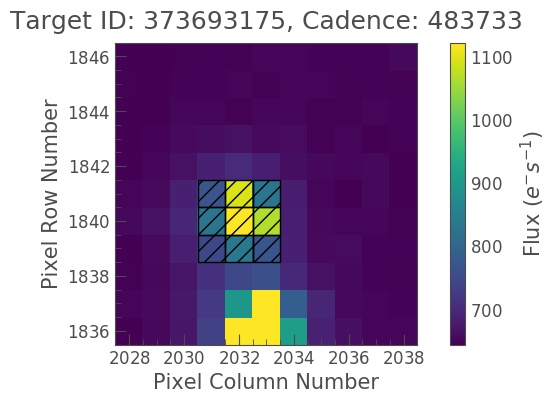

In [6]:
tpf_2min_11px_hdu = fits.open(tpf_2min_11px_file)
apimg = (tpf_2min_11px_hdu[2].data)
trg_ap = np.bitwise_and(apimg, 2) / float(2)
bkg_ap = np.bitwise_and(apimg, 4) / float(4)
trg_mask = np.ma.make_mask(trg_ap)
bkg_mask = np.ma.make_mask(bkg_ap)
tpf_2min_11px.plot(aperture_mask=trg_mask, mask_color='k')

### Alternative way to monitor the mask from the TESS pipeline:

There is a <i>pipeline_mask</i> method, which can be used to have a look. It's a boolean array, as can be seen, marking the pixels in the mask with $True$, and the pixels not included in the mask with $False$.

In [7]:
tpf_2min_11px.pipeline_mask

array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False,  True,  True,  True, False, False, False,
        False, False],
       [False, False, False,  True,  True,  True, False, False, False,
        False, False],
       [False, False, False,  True,  True,  True, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, Fal

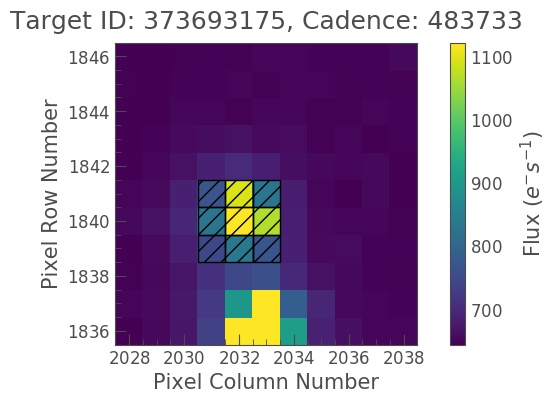

In [8]:
%matplotlib inline
tpf_2min_11px.plot(aperture_mask=tpf_2min_11px.pipeline_mask, mask_color='k')

## The background mask

And now, let's have a look at the background mask.

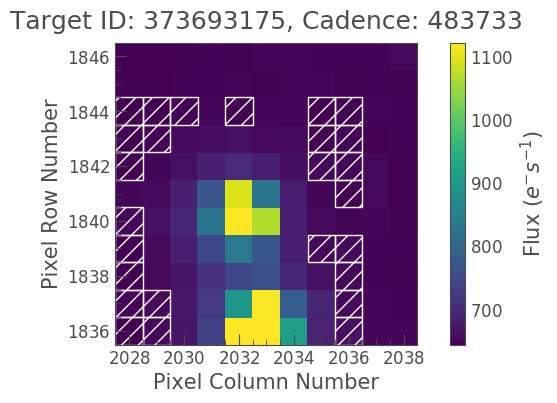

In [9]:
%matplotlib inline
tpf_2min_11px.plot(aperture_mask=bkg_mask, mask_color='w')

### Note: ###

We should be satisfied with the target and aperture masks. They look fine, not allowing any contamination. So let's what flux we are going to measure from these although we can change them. For the sake of simplicity and time concerns, let's stick with this. But we can discuss how we can change the aperture and background masks manually and attempt to obtain a better light curve. However, most TESS light curves derived by the SPOC pipeline are already optimized for transit photometry.

##  Simple Aperture Photometry

One can actually use t pipeline masks to extract the light curve too. But we are going to do this by extracting it from the TPF.

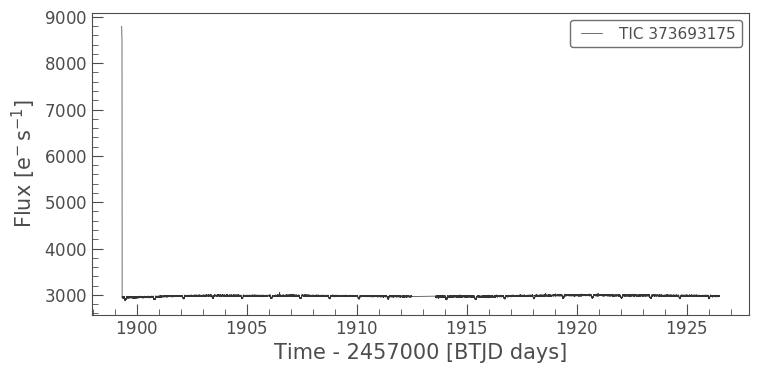

In [11]:
lc_pipeline_2min = tpf_2min_11px.extract_aperture_photometry()
lc_pipeline_2min.plot()

There is an artifact right at the beginning we should get rid of. But already transits can be recognized. 

## TPF Generated 2-min Flux from the Same Aperture

Now let's try to extract the SAP Flux ourselves from the TPF by making use of the target and background fluxes in the selected pixels by the pipeline.

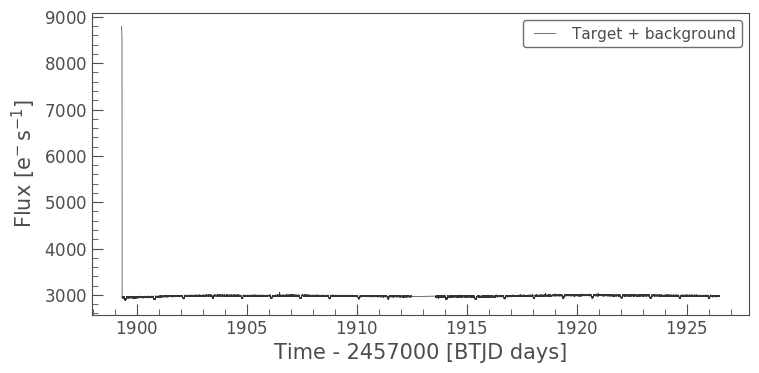

In [12]:
# extract the light curve from the eparture mask and plot it
%matplotlib inline
trg_bkg_lc_2min_11px = tpf_2min_11px.to_lightcurve(aperture_mask=trg_mask)
trg_bkg_lc_2min_11px.plot(label='Target + background')

Number of background pixels:  26
Number of target pixels:  9


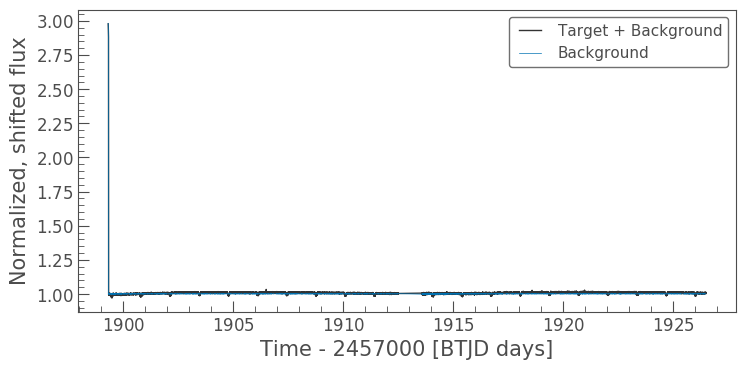

In [13]:
# Estimate the background:
%matplotlib inline
n_background_pixels = bkg_mask.sum()
print("Number of background pixels: ", n_background_pixels)
n_target_pixels = trg_mask.sum()
print("Number of target pixels: ", n_target_pixels)
bkg_lc_per_pixel = tpf_2min_11px.to_lightcurve(
    aperture_mask=bkg_mask) / n_background_pixels
bkg_estimate_lc = bkg_lc_per_pixel * n_target_pixels
# This the equivalent of 'BKG_FLUX' in light curve files!
# Now plot this on top of the target + background light curve
# after a normalization to a common level
common_normalization = np.nanpercentile(trg_bkg_lc_2min_11px.flux, 10)
ax = (trg_bkg_lc_2min_11px / common_normalization).plot(normalize=False,
                                             label='Target + Background', lw=1)
(bkg_estimate_lc / common_normalization + 1).plot(ax=ax, normalize=False, label='Background',
                                                         ylabel='Normalized, shifted flux')

Note that the artificial peak at the beginning is from the background, which will go away when we subtract it.

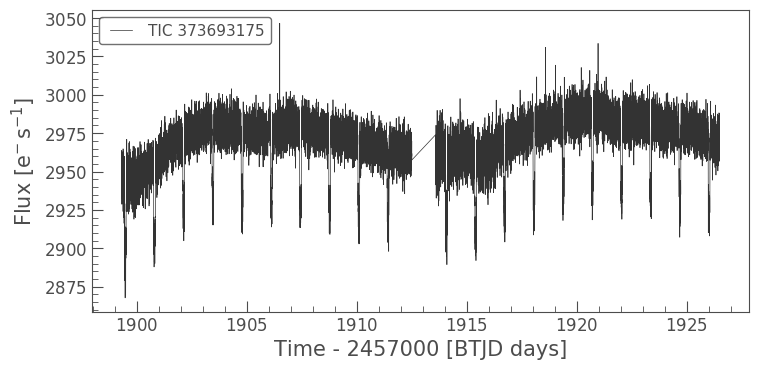

In [14]:
# Now show the corrected light curve
%matplotlib inline
corrected_lc_2min_11px = trg_bkg_lc_2min_11px - bkg_estimate_lc.flux
corrected_lc_2min_11px.plot()

## Result: ##

Yes it does remove the background noise. Obviously, there is out-of-transit variability (wavy-nature of the overall light curve if you ignore the transits). There could be some flares too in the shape of peaks. We'll not care about them for the moment. But let's see if TESS pipeline has the same light curve to double-check!

### SAP Flux Light Curve from the light curve file

Now open the SAP flux light curve from the light curve file and compare.

1% (188/18807) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
INFO:lightkurve.utils:1% (188/18807) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  


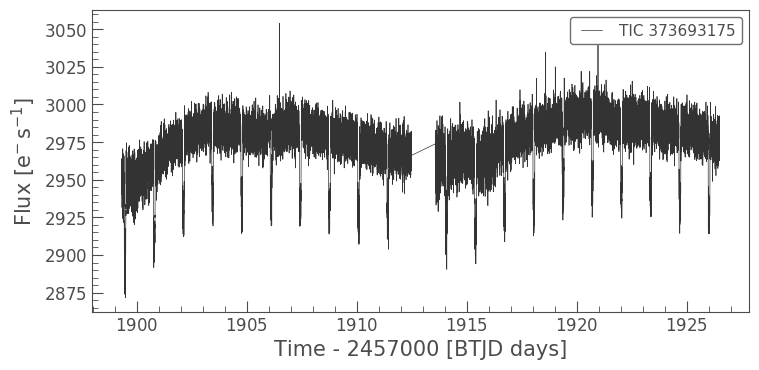

In [15]:
# Open the 2-min cadence light curve file downloaded from MAST
# We do not extract from the 2-min cadence TPF for the moment
# We'll do that and compare a bit later
%matplotlib inline
lc_2min_file = "tess2020049080258-s0022-0000000373693175-0174-s_lc.fits"
lc_2min_SAP = lk.TessLightCurveFile(lc_2min_file, quality_bitmask='default').SAP_FLUX
lc_2min_SAP.plot()

## Write the SAP Flux to a File ##

Let's write the SAP Flux within a simpler form to a file. That's why I commented out the to_csv method of a lightkurve file since I want to dump only the time stamps (added 2457000.0), fluxes and their errors and ignore $nan$ values. 

In [16]:
lc_2min_SAP_final = lk.LightCurve(time=lc_2min_SAP.time, 
                                 flux = lc_2min_SAP.flux,
                                 flux_err = lc_2min_SAP.flux_err)
# get rid of nan's
lc_2min_SAP_final = lc_2min_SAP_final.remove_nans()
lc_2min_SAP_final.write("HAT-P-36_TESS_SAP_lc.dat", format="ascii")

# PDCSAP Flux in 2-minute Cadence Data

PDCSAP-Flux is pre-data condition simple aperture photometry flux, which is optimized for transit signals. So let's open the light curve file again and PDC SAP Flux for the target derived by the TESS SPOC pipeline. Then we'll compare it with the SAP Flux.

1% (188/18807) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
INFO:lightkurve.utils:1% (188/18807) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
1% (188/18807) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
INFO:lightkurve.utils:1% (188/18807) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  after removing the cwd from sys.path.
1% (188/18807) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
INFO:lightkurve.utils:1% (188/18807) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a fut

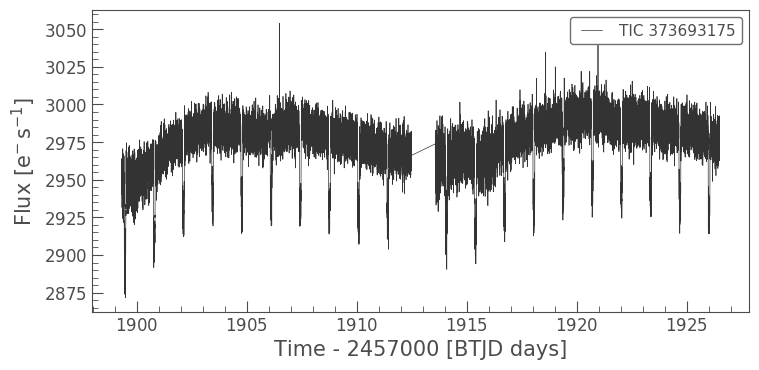

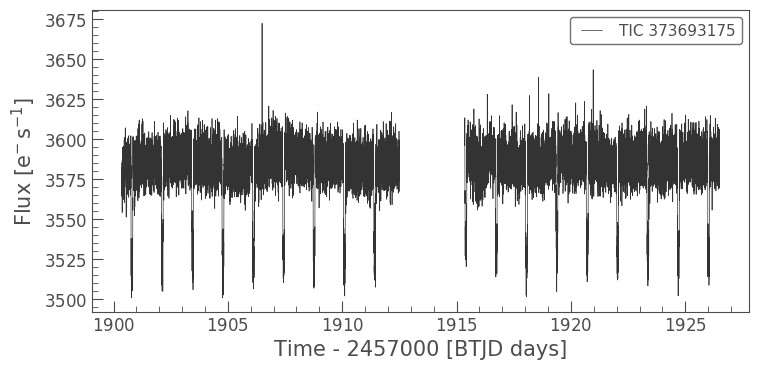

In [17]:
%matplotlib inline
lc_2min_file = "tess2020049080258-s0022-0000000373693175-0174-s_lc.fits"
lc_2min = lk.TessLightCurveFile(lc_2min_file, quality_bitmask='default')
lc_2min_SAP = lk.TessLightCurveFile(lc_2min_file, quality_bitmask='default').SAP_FLUX
lc_2min_PDCSAP = lk.TessLightCurveFile(lc_2min_file, quality_bitmask='default').PDCSAP_FLUX
lc_2min_SAP.plot()
lc_2min_PDCSAP.plot()
lc_2min_SAP.time += 2457000.
lc_2min_PDCSAP.time += 2457000.

Obviously, PDCSAP Flux enhances the transit signal and "shaves" the out-of-transit variability.Out-of-transit variability can be needed to calculate the rotation rate of the host star or its pulsation frequencies. But for mid-transit time measurements, it's better to work on PDCSAP-Flux because it is optimized to enhance the transit. "Flare-looking like" signals are still there. Let's write the PDCSAP flux to a file in a simpler format too.

In [18]:
lc_2min_PDCSAP_final = lk.LightCurve(time=lc_2min_PDCSAP.time, 
                                 flux = lc_2min_PDCSAP.flux,
                                 flux_err = lc_2min_PDCSAP.flux_err)
# get rid of nan's
lc_2min_PDCSAP_final = lc_2min_PDCSAP_final.remove_nans()
lc_2min_PDCSAP_final.write("HAT-P-36_TESS_PDCSAP_lc.dat", format="ascii")

# LC-DETREND Column in DVT File

Now let's see what we have in the detrended flux column of the dvt file. We have also externally downloaded this file from the MAST for ease of use. Let's see the information about this file.

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
lc_2min_dvt_file = "tess2020050191121-s0022-s0022-0000000373693175-00309_dvt.fits"
fits.info(lc_2min_dvt_file)

Filename: tess2020050191121-s0022-s0022-0000000373693175-00309_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  TCE_1         1 BinTableHDU     92   19579R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  Statistics    1 BinTableHDU    157   19579R x 38C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


As you can see the data is in the first (1) extension of the HDU file. Now we are going to plot it.

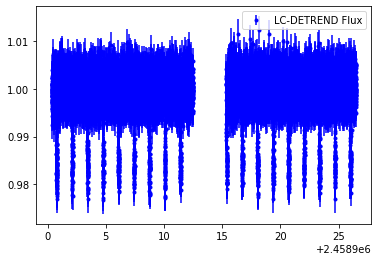

In [20]:
lc_2min_dvt_hdu = fits.open(lc_2min_dvt_file)
lc_2min_dvt = (lc_2min_dvt_hdu[1].data)
# DVF flux is normalized to 0 so just add 1 for convenience!
plt.errorbar(lc_2min_dvt['TIME']+2457000., lc_2min_dvt['LC_DETREND']+1.00, yerr=lc_2min_dvt['LC_INIT_ERR'],\
            fmt='.', c='b',  label='LC-DETREND Flux')

plt.legend(loc='best')
plt.show()

Since the SPOC pipeline calculates a period and a reference mid-transit time for the object, it can calculate orbital phase as well. It records it in the <i>'PHASE'</i> column of the pandas dataframe just like it records the time information in <i>'TIME'</i>, detrended flux in <i>'LC_DETREND</i> and its error in the <i>'LC_INIT_ERR'</i> columns.

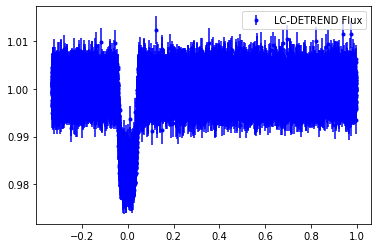

In [21]:
%matplotlib inline
plt.errorbar(lc_2min_dvt['PHASE'], lc_2min_dvt['LC_DETREND']+1.00, yerr=lc_2min_dvt['LC_INIT_ERR'],\
            fmt='.', c='b',  label='LC-DETREND Flux')

plt.legend(loc='best')
plt.show()

# Final Result: #

Clearly, the flare-like features are gone too and we have even a better light curve than PDCSAP. We can dump this to a text file and make our measurements from this, plot as we like it and remove extra linear trends if they do still exist due to magnetic activity with AIJ. While we are writing we should be careful about "nan" values. So let's remove the nan's first and dump the light curve to a file in ascii format. Also note that the detrended fluxes are normalized to 0. We are going to add 1 to normalize them to 1 as we have done for all other light curves. We are also going to add 2450000 to the values in the column 'TIME' because TESS-BJD is less than BJD-TDB by this amount for simplicity.

In [24]:
lc_2min_dvt_final = lk.LightCurve(time=lc_2min_dvt['TIME']+2457000, 
                                  flux= lc_2min_dvt['LC_DETREND']+1.00,
                                  flux_err = lc_2min_dvt['LC_INIT_ERR'])
lc_2min_dvt_final = lc_2min_dvt_final.remove_nans()
lc_2min_dvt_final.write("HAT-P-36_TESS_DVT_lc.dat", format="ascii")

And we are done!